In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns

DATA_PATH = "../data/"

#### Data load and separation in "keep_fame" and "lose_fame" populations
The keep_fame and lose fame_populations were loaded after having computed the matching pairs were loaded. The associated timeseries and metadata dataframes were loaded as well.

In [2]:
# channels_df separated in "keep_fame" and "lose_fame" after matching
keep_fame = pd.read_csv(f"{DATA_PATH}keep_fame_after_matching.tsv.gz", compression='gzip', sep = '\t')
lose_fame = pd.read_csv(f"{DATA_PATH}lose_fame_after_matching.tsv.gz", compression='gzip', sep = '\t')

In [3]:
keep_fame.shape[0], lose_fame.shape[0]

(163, 163)

In [4]:
# timeseries_df loading and separation in "keep_fame" and "lose_fame" after matching
timeseries_df = pd.read_csv(f"{DATA_PATH}timeseries_df_filtered.tsv.gz", compression='gzip', sep = '\t', parse_dates=['datetime', 'max_growth_date'])
keep_fame_ts = timeseries_df[timeseries_df['channel'].isin(keep_fame['channel'])]
lose_fame_ts = timeseries_df[timeseries_df['channel'].isin(lose_fame['channel'])]

In [5]:
len(keep_fame_ts.groupby("channel")), len(lose_fame_ts.groupby("channel"))

(163, 163)

In [6]:
# metavideos df loading and separation between lose and keep fame
meta_video_filt_original = pd.read_csv(f"{DATA_PATH}videos_metadata_filtered_population.tsv.gz", sep='\t', compression='gzip')

# checked that there is a video without category, so we remove it
meta_video_filt_original = meta_video_filt_original.drop(meta_video_filt_original[meta_video_filt_original["categories"].isna()].index, axis=0)

# we remove the videos that are not in the two populations
keep_fame_metavideos = meta_video_filt_original[meta_video_filt_original['channel_id'].isin(keep_fame['channel'])]
lose_fame_metavideos = meta_video_filt_original[meta_video_filt_original['channel_id'].isin(lose_fame['channel'])]

In [7]:
# metavideos dfs with max growth date
keep_fame_metavideos = keep_fame_metavideos.merge(keep_fame_ts.rename(columns={"datetime": "min_date"}).groupby('channel')[['max_growth_date', "min_date"]].min(), left_on='channel_id', right_on='channel')
keep_fame_metavideos = keep_fame_metavideos.merge(keep_fame_ts.rename(columns={"datetime": "max_date"}).groupby('channel')["max_date"].max(), left_on='channel_id', right_on='channel')
lose_fame_metavideos = lose_fame_metavideos.merge(lose_fame_ts.rename(columns={"datetime": "min_date"}).groupby('channel')[['max_growth_date', "min_date"]].min(), left_on='channel_id', right_on='channel')
lose_fame_metavideos = lose_fame_metavideos.merge(lose_fame_ts.rename(columns={"datetime": "max_date"}).groupby('channel')["max_date"].max(), left_on='channel_id', right_on='channel')

In [8]:
len(keep_fame_metavideos.groupby('channel_id')), len(lose_fame_metavideos.groupby('channel_id'))

(163, 163)

#### Dataframe separation between before and after growth date
Should creators stay consistent with their content or try to adapt it to the interests of their newly-found large audience? To answer this question, we analysed the features of each channel before and after going viral. To avoid bias, we only selected the channels that had videos before and after their peak. We therefore ended up with 163 channels for each population. We need further filtering to eliminate those channels (and their match) from whom we don't have any data about the videos published, either before or after the peak. We therefore end up with 126 channels for each population.

In [9]:
matched_channels = pd.read_csv(f"{DATA_PATH}matched_channels.tsv.gz", compression='gzip', sep = '\t')

In [10]:
# keep and lose metavideos dfs divided before and after max growth date
keep_metavideos_after_sudden_growth = keep_fame_metavideos[
    (keep_fame_metavideos["upload_date"] > keep_fame_metavideos["max_growth_date"]) &
    (keep_fame_metavideos["upload_date"] <= keep_fame_metavideos["max_date"])
].copy()
lose_metavideos_after_sudden_growth = lose_fame_metavideos[
    (lose_fame_metavideos["upload_date"] > lose_fame_metavideos["max_growth_date"]) &
    (lose_fame_metavideos["upload_date"] <= lose_fame_metavideos["max_date"])
].copy()
keep_metavideos_before_sudden_growth = keep_fame_metavideos[
    (keep_fame_metavideos["upload_date"] <= keep_fame_metavideos["max_growth_date"]) &
    (keep_fame_metavideos["upload_date"] >= keep_fame_metavideos["min_date"])
].copy()
lose_metavideos_before_sudden_growth = lose_fame_metavideos[
    (lose_fame_metavideos["upload_date"] <= lose_fame_metavideos["max_growth_date"]) &
    (lose_fame_metavideos["upload_date"] >= lose_fame_metavideos["min_date"])
].copy()

In [11]:
# filter video data of "keep" channels that have videos both before sudden growth and after sudden growth
channels_k_b = keep_metavideos_before_sudden_growth["channel_id"].unique()
channels_k_a = keep_metavideos_after_sudden_growth["channel_id"].unique()
index_keep = set.intersection(set(channels_k_b), set(channels_k_a))

print(f"Number of keep fame channels selected: {index_keep.__len__()}")

keep_metavideos_before_sudden_growth = keep_metavideos_before_sudden_growth[keep_metavideos_before_sudden_growth["channel_id"].isin(index_keep)]
keep_metavideos_after_sudden_growth = keep_metavideos_after_sudden_growth[keep_metavideos_after_sudden_growth["channel_id"].isin(index_keep)]


Number of keep fame channels selected: 133


In [12]:
# filter video data of "lose" channels that have videos both before sudden growth and after sudden growth
channels_l_b = lose_metavideos_before_sudden_growth["channel_id"].unique()
channels_l_a = lose_metavideos_after_sudden_growth["channel_id"].unique()
index_lose = set.intersection(set(channels_l_b), set(channels_l_a))

print(f"Number of lose fame channels selected: {index_lose.__len__()}")

lose_metavideos_before_sudden_growth = lose_metavideos_before_sudden_growth[lose_metavideos_before_sudden_growth["channel_id"].isin(index_lose)]
lose_metavideos_after_sudden_growth = lose_metavideos_after_sudden_growth[lose_metavideos_after_sudden_growth["channel_id"].isin(index_lose)]

Number of lose fame channels selected: 108


In [13]:
# remove channels that don't have a match anymore
removed_keep = matched_channels[~matched_channels["channel_keep"].isin(index_keep)]
removed_lose = matched_channels[~matched_channels["channel_lose"].isin(index_lose)]
index_remove = set.union(set(removed_keep["channel_lose"]), set(removed_lose["channel_keep"]))

keep_metavideos_after_sudden_growth = keep_metavideos_after_sudden_growth[~keep_metavideos_after_sudden_growth["channel_id"].isin(index_remove)]
keep_metavideos_before_sudden_growth = keep_metavideos_before_sudden_growth[~keep_metavideos_before_sudden_growth["channel_id"].isin(index_remove)]
lose_metavideos_after_sudden_growth = lose_metavideos_after_sudden_growth[~lose_metavideos_after_sudden_growth["channel_id"].isin(index_remove)]
lose_metavideos_before_sudden_growth = lose_metavideos_before_sudden_growth[~lose_metavideos_before_sudden_growth["channel_id"].isin(index_remove)]


In [14]:
print(f"Number of channels selected per group: {lose_metavideos_after_sudden_growth['channel_id'].unique().__len__()}")

Number of channels selected per group: 88


In [15]:
# filter timeseries data of "keep" and "lose" channels that have videos both before sudden growth and after sudden growth
keep_fame_ts = keep_fame_ts[keep_fame_ts["channel"].isin(keep_metavideos_after_sudden_growth['channel_id'])]
lose_fame_ts = lose_fame_ts[lose_fame_ts["channel"].isin(lose_metavideos_after_sudden_growth['channel_id'])]


In [16]:
keep_fame_channels = keep_fame[keep_fame["channel"].isin(keep_metavideos_after_sudden_growth['channel_id'])]
lose_fame_channels = lose_fame[lose_fame["channel"].isin(lose_metavideos_after_sudden_growth['channel_id'])]

In [17]:
cat_distr_for_plotting = pd.concat([keep_fame_channels.groupby("category_cc").count()["name_cc"], lose_fame_channels.groupby("category_cc").count()["join_date"]], axis=1)\
    .rename(columns={"name_cc":"keep", "join_date":"lose"})

cat_distr_for_plotting.reset_index(inplace=True)
cat_distr_for_plotting = cat_distr_for_plotting.melt('category_cc', var_name='population', value_name='vals')


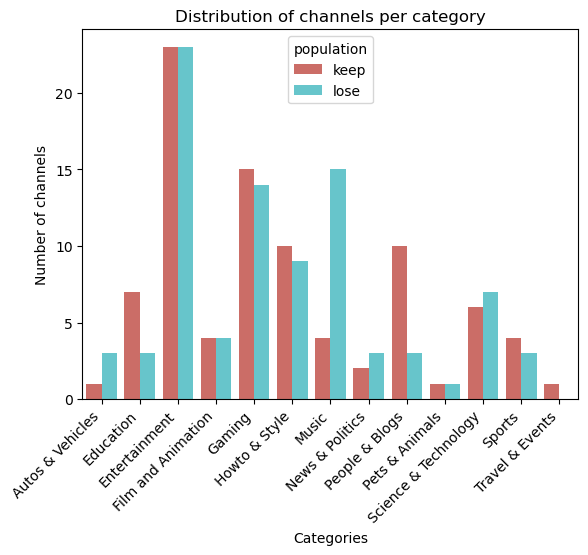

In [18]:
sns.barplot(data=cat_distr_for_plotting, x="category_cc", y='vals', hue="population", palette="hls")
plt.xticks(rotation=45, ha="right");
plt.xlabel("Categories");
plt.ylabel("Number of channels");
plt.title("Distribution of channels per category");

### Analysis
We decided to compare the two populations across many selected features, distinguishing each time between the time period preceding and following the viral peak. The selected features are frequency of publications, length of videos, number of tags and distribution of categories over the videos.

##### Frequency of publication
To compute the frequency of publications we divided the number of videos before and after the sudden growth for both populations by the time of observation (respectively 12 weeks before and 14 weeks after the peak for both groups). The same was done for the length of videos and the number of tags. 

In [19]:
# compute number of videos posted by each channel before and after sudden growth
keep_num_metavideos_per_channel_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").count()["duration"]
keep_num_metavideos_per_channel_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").count()["duration"]
lose_num_metavideos_per_channel_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").count()["duration"]
lose_num_metavideos_per_channel_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").count()["duration"]

In [20]:
# compute time of observation of each channel before and after sudden growth
keep_videos_time_after_sudden_growth = (keep_fame_ts.groupby("channel")["datetime"].max() - keep_fame_ts.groupby("channel")["max_growth_date"].mean()).dt.days
lose_videos_time_after_sudden_growth = (lose_fame_ts.groupby("channel")["datetime"].max() - lose_fame_ts.groupby("channel")["max_growth_date"].mean()).dt.days
keep_videos_time_before_sudden_growth = (keep_fame_ts.groupby("channel")["max_growth_date"].mean() - keep_fame_ts.groupby("channel")["datetime"].min()).dt.days
lose_videos_time_before_sudden_growth = (lose_fame_ts.groupby("channel")["max_growth_date"].mean() - lose_fame_ts.groupby("channel")["datetime"].min()).dt.days

In [21]:
# compute frequency of publication of each channel before and after sudden growth
freq_publication_keep_after_sudden_growth = keep_num_metavideos_per_channel_after_sudden_growth / keep_videos_time_after_sudden_growth
freq_publication_lose_after_sudden_growth = lose_num_metavideos_per_channel_after_sudden_growth / lose_videos_time_after_sudden_growth
freq_publication_keep_before_sudden_growth = keep_num_metavideos_per_channel_before_sudden_growth / keep_videos_time_before_sudden_growth
freq_publication_lose_before_sudden_growth = lose_num_metavideos_per_channel_before_sudden_growth / lose_videos_time_before_sudden_growth

In [22]:
# paired t-test for frequency of publication before and after sudden growth of "keep" channels
scs.ttest_rel(freq_publication_keep_after_sudden_growth, freq_publication_keep_before_sudden_growth)

Ttest_relResult(statistic=-1.0589170180142942, pvalue=0.2925687472851107)

In [23]:
# paired t-test for frequency of publication before and after sudden growth of "lose" channels
scs.ttest_rel(freq_publication_lose_after_sudden_growth, freq_publication_lose_before_sudden_growth)

Ttest_relResult(statistic=0.3443793685842897, pvalue=0.7313920473891125)

In [24]:
# independent t-test for frequency of publication between "keep" and "lose" channels after sudden growth
scs.ttest_ind(freq_publication_keep_after_sudden_growth, freq_publication_lose_after_sudden_growth)

Ttest_indResult(statistic=-1.6680602814988494, pvalue=0.09710235064515745)

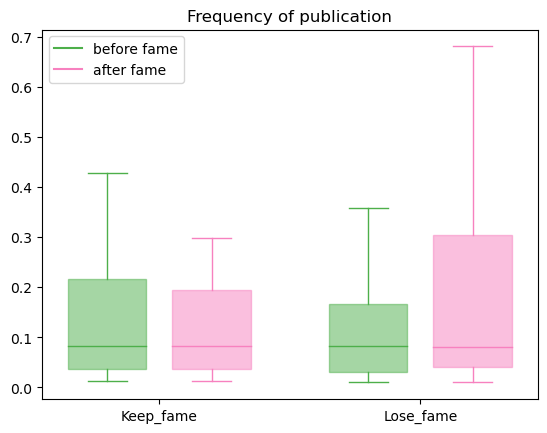

In [25]:
data_a = [freq_publication_keep_before_sudden_growth, freq_publication_keep_after_sudden_growth]
data_b = [freq_publication_lose_before_sudden_growth, freq_publication_lose_after_sudden_growth]

ticks = ['Keep_fame', 'Lose_fame']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6, patch_artist=True)
bpl['boxes'][0].set(alpha=0.5)
bpl['boxes'][1].set(alpha=0.5)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6, patch_artist=True)
bpr['boxes'][0].set(alpha=0.5)
bpr['boxes'][1].set(alpha=0.5)

plt.xticks([0, 2], ticks)
set_box_color(bpl, '#4daf4a') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#f781bf')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#4daf4a', label='before fame')
plt.plot([], c='#f781bf', label= 'after fame')
plt.title("Frequency of publication")
plt.legend();

##### Length of videos

In [26]:
length_keep_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").mean()["duration"]
length_lose_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").mean()["duration"]
length_keep_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").mean()["duration"]
length_lose_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").mean()["duration"]

In [27]:
# paired t-test for length of videos before and after sudden growth of "keep" channels
scs.ttest_rel(length_keep_after_sudden_growth, length_keep_before_sudden_growth)

Ttest_relResult(statistic=-0.5596123311397958, pvalue=0.5771818283849695)

In [28]:
# paired t-test for length of videos before and after sudden growth of "lose" channels
scs.ttest_rel(length_lose_after_sudden_growth, length_lose_before_sudden_growth)

Ttest_relResult(statistic=-1.2302189834113872, pvalue=0.22193121638665927)

In [29]:
# independent t-test for length of videos between "keep" and "lose" channels after sudden growth
scs.ttest_ind(length_keep_after_sudden_growth, length_lose_after_sudden_growth)

Ttest_indResult(statistic=0.943851464746833, pvalue=0.34655427479697165)

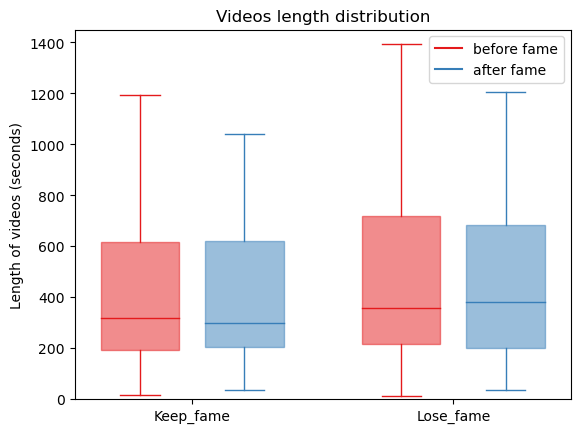

In [30]:
data_a = [length_keep_before_sudden_growth, length_keep_after_sudden_growth]
data_b = [length_lose_before_sudden_growth, length_lose_after_sudden_growth, ]

ticks = ['Keep_fame', 'Lose_fame']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()
plt.ylim(top=1450)
plt.ylabel("Length of videos (seconds)")

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6, patch_artist=True)
bpl['boxes'][0].set(alpha=0.5)
bpl['boxes'][1].set(alpha=0.5)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6, patch_artist=True)
bpr['boxes'][0].set(alpha=0.5)
bpr['boxes'][1].set(alpha=0.5)
plt.xticks([0, 2], ticks)
set_box_color(bpl, '#e41a1c') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#377eb8')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#e41a1c', label='before fame')
plt.plot([], c='#377eb8', label='after fame')
plt.title("Videos length distribution")
plt.legend();

#### Number of tags

In [31]:
numtags_lose_metavideo_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_keep_metavideo_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_lose_metavideo_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_keep_metavideo_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").mean()["num_tags"]

In [32]:
scs.ttest_rel(numtags_lose_metavideo_after_sudden_growth, numtags_lose_metavideo_before_sudden_growth)

Ttest_relResult(statistic=0.48584422955995643, pvalue=0.6282990328345832)

In [33]:
scs.ttest_rel(numtags_keep_metavideo_after_sudden_growth, numtags_keep_metavideo_before_sudden_growth)

Ttest_relResult(statistic=-0.05739934355886939, pvalue=0.9543587132378146)

In [34]:
scs.ttest_ind(numtags_lose_metavideo_after_sudden_growth, numtags_keep_metavideo_after_sudden_growth)

Ttest_indResult(statistic=-0.7530421564187064, pvalue=0.4524422333441098)

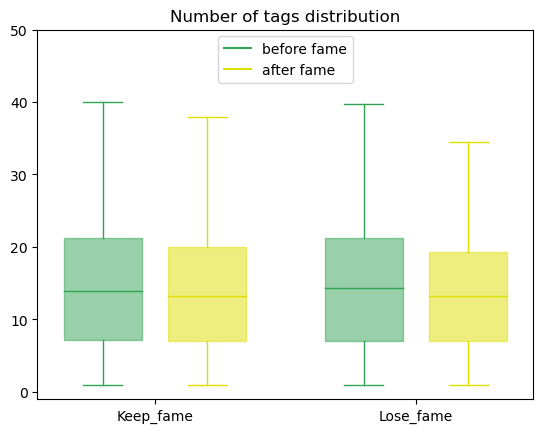

In [35]:
data_a = [numtags_keep_metavideo_before_sudden_growth, numtags_keep_metavideo_after_sudden_growth]
data_b = [numtags_lose_metavideo_before_sudden_growth, numtags_lose_metavideo_after_sudden_growth]

ticks = ['Keep_fame', 'Lose_fame']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()
plt.ylim(bottom=-1, top=50)

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6, patch_artist=True)
bpl['boxes'][0].set(alpha=0.5)
bpl['boxes'][1].set(alpha=0.5)

bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6,  patch_artist=True)
bpr['boxes'][0].set(alpha=0.5)
bpr['boxes'][1].set(alpha=0.5)
plt.xticks([0, 2], ticks)
set_box_color(bpl, '#31a354') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#dede00')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#31a354', label='before fame')
plt.plot([], c='#dede00', label='after fame')
plt.title("Number of tags distribution")
plt.legend(loc='upper center');

#### Number of likes over number of views per channel

In [36]:
keep_metavideos_before_sudden_growth["like_views_ratio"] = keep_metavideos_before_sudden_growth["like_count"]/keep_metavideos_before_sudden_growth["view_count"]
keep_metavideos_after_sudden_growth["like_views_ratio"] = keep_metavideos_after_sudden_growth["like_count"]/keep_metavideos_after_sudden_growth["view_count"]
lose_metavideos_before_sudden_growth["like_views_ratio"] = lose_metavideos_before_sudden_growth["like_count"]/lose_metavideos_before_sudden_growth["view_count"]
lose_metavideos_after_sudden_growth["like_views_ratio"] = lose_metavideos_after_sudden_growth["like_count"]/lose_metavideos_after_sudden_growth["view_count"]


In [37]:
k_b_ratio = keep_metavideos_before_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
k_a_ratio = keep_metavideos_after_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
l_b_ratio = lose_metavideos_before_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
l_a_ratio = lose_metavideos_after_sudden_growth.groupby('channel_id')["like_views_ratio"].mean()
k_index_filter = (k_b_ratio.isna()) | (k_a_ratio.isna())
l_index_filter = (l_b_ratio.isna()) | (l_a_ratio.isna())
k_b_ratio = k_b_ratio[~k_index_filter]
k_a_ratio = k_a_ratio[~k_index_filter]
l_b_ratio = l_b_ratio[~l_index_filter]
l_a_ratio = l_a_ratio[~l_index_filter]

In [38]:
print(f"Test between keep_before and keep_after: {scs.ttest_rel(k_b_ratio, k_a_ratio)}")
print(f"Test between lose_before and lose_after: {scs.ttest_rel(l_b_ratio, l_a_ratio)}")
print(f"Test between keep_before and lose_before: {scs.ttest_ind(k_b_ratio, l_b_ratio)}")
print(f"Test between keep_after and lose_after: {scs.ttest_ind(k_a_ratio, l_a_ratio)}")

Test between keep_before and keep_after: Ttest_relResult(statistic=-2.0586033978300615, pvalue=0.04263094891882229)
Test between lose_before and lose_after: Ttest_relResult(statistic=-0.45951829270929406, pvalue=0.6470633506451422)
Test between keep_before and lose_before: Ttest_indResult(statistic=1.3302783067812203, pvalue=0.18524037302693072)
Test between keep_after and lose_after: Ttest_indResult(statistic=2.020917020903831, pvalue=0.0448857495533731)


In [39]:
k_b_ratio.mean(), k_a_ratio.mean(), l_b_ratio.mean(), l_a_ratio.mean()

(0.03944394408655639,
 0.044295759528276836,
 0.03374742056624559,
 0.03465108381573545)

#### Number of dislikes over number of views per channel

In [40]:
keep_metavideos_before_sudden_growth["dislike_views_ratio"] = keep_metavideos_before_sudden_growth["dislike_count"]/keep_metavideos_before_sudden_growth["view_count"]
keep_metavideos_after_sudden_growth["dislike_views_ratio"] = keep_metavideos_after_sudden_growth["dislike_count"]/keep_metavideos_after_sudden_growth["view_count"]
lose_metavideos_before_sudden_growth["dislike_views_ratio"] = lose_metavideos_before_sudden_growth["dislike_count"]/lose_metavideos_before_sudden_growth["view_count"]
lose_metavideos_after_sudden_growth["dislike_views_ratio"] = lose_metavideos_after_sudden_growth["dislike_count"]/lose_metavideos_after_sudden_growth["view_count"]


In [41]:
k_b_ratio = keep_metavideos_before_sudden_growth.groupby('channel_id')["dislike_views_ratio"].mean()
k_a_ratio = keep_metavideos_after_sudden_growth.groupby('channel_id')["dislike_views_ratio"].mean()
l_b_ratio = lose_metavideos_before_sudden_growth.groupby('channel_id')["dislike_views_ratio"].mean()
l_a_ratio = lose_metavideos_after_sudden_growth.groupby('channel_id')["dislike_views_ratio"].mean()
k_index_filter = (k_b_ratio.isna()) | (k_a_ratio.isna())
l_index_filter = (l_b_ratio.isna()) | (l_a_ratio.isna())
k_b_ratio = k_b_ratio[~k_index_filter]
k_a_ratio = k_a_ratio[~k_index_filter]
l_b_ratio = l_b_ratio[~l_index_filter]
l_a_ratio = l_a_ratio[~l_index_filter]

In [42]:
print(f"Test between keep_before and keep_after: {scs.ttest_rel(k_b_ratio, k_a_ratio)}")
print(f"Test between lose_before and lose_after: {scs.ttest_rel(l_b_ratio, l_a_ratio)}")
print(f"Test between keep_before and lose_before: {scs.ttest_ind(k_b_ratio, l_b_ratio)}")
print(f"Test between keep_after and keep_after: {scs.ttest_ind(k_a_ratio, l_a_ratio)}")

Test between keep_before and keep_after: Ttest_relResult(statistic=0.36064964577953285, pvalue=0.719266730003159)
Test between lose_before and lose_after: Ttest_relResult(statistic=-0.023551257660905715, pvalue=0.9812657530970369)
Test between keep_before and lose_before: Ttest_indResult(statistic=-0.997391561833167, pvalue=0.3200004145375966)
Test between keep_after and keep_after: Ttest_indResult(statistic=-1.390936985305759, pvalue=0.1660731496053388)


In [43]:
k_b_ratio.mean(), k_a_ratio.mean(), l_b_ratio.mean(), l_a_ratio.mean()

(0.0020698895511244296,
 0.002008205776349121,
 0.0024948077256422255,
 0.0025004412532754878)

## Distribution of categories over the videos

In [44]:
# save all categories to plot the distribution later
categories = meta_video_filt_original.categories.unique()
categories = ["categories_" + s for s in categories]

In [45]:
def get_distribution_of_videos_over_category(df, categories_list, name):
    '''
    This function computes the distribution of videos over categories for a given dataframe
    '''
    print(name)
    # dummify categories in metavideos dataframes
    df_dummified = pd.get_dummies(df[['channel_id', 'crawl_date','categories']], columns=['categories'], dtype=int)

    # fill missing categories with 0
    df_dummified = df_dummified.reindex(columns = df_dummified.columns.tolist() + \
        [category for category in categories if category not in df_dummified.columns], \
        fill_value=0)

    # Distribution of videos over categories
    df_dummified_grouped = df_dummified.groupby("channel_id")
    num_videos_tot = df_dummified_grouped.count()["crawl_date"]
    num_videos_per_category = df_dummified_grouped.sum()
    prop_videos_per_category = num_videos_per_category.divide(num_videos_tot, axis=0)
    display(prop_videos_per_category.head())
    print(prop_videos_per_category.shape)
    print(f"Check the sum of proportions is equal to 1: min_sum_categories = {round(prop_videos_per_category.sum(axis = 1).min(),3)}.")
    assert np.isclose(prop_videos_per_category.sum(axis = 1).min(), 1)

    return prop_videos_per_category



In [46]:
prop_videos_per_cat_k_a = get_distribution_of_videos_over_category(keep_metavideos_after_sudden_growth, categories, "Keep after sudden growth channels") 
prop_videos_per_cat_k_b = get_distribution_of_videos_over_category(keep_metavideos_before_sudden_growth, categories, "Keep before sudden growth channels")
prop_videos_per_cat_l_a = get_distribution_of_videos_over_category(lose_metavideos_after_sudden_growth, categories, "Lose after sudden growth channels")
prop_videos_per_cat_l_b = get_distribution_of_videos_over_category(lose_metavideos_before_sudden_growth, categories, "Lose before sudden growth channels")

Keep after sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events
channel_id,,,,,,,,,,,,,,,
UC-DVtRZZhbm1GRCkr7OSZxw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC0EUyJBJ1Ms90_XCqU01Ocw,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC1--Lh0c2PhkyRxpvNcXWaA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC1xnncYc7586km_rIYQLtLQ,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
UC21l3rjgxTpL_3TkfCqK8Iw,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(88, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.
Keep before sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events,categories_Nonprofits & Activism
channel_id,,,,,,,,,,,,,,,
UC-DVtRZZhbm1GRCkr7OSZxw,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
UC0EUyJBJ1Ms90_XCqU01Ocw,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
UC1--Lh0c2PhkyRxpvNcXWaA,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
UC1xnncYc7586km_rIYQLtLQ,0.314286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.657143,0.0
UC21l3rjgxTpL_3TkfCqK8Iw,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


(88, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.
Lose after sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events,categories_Nonprofits & Activism
channel_id,,,,,,,,,,,,,,,
UC-1qy7V-dMBaC-5xfrF-Akw,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
UC-XebCD-RF_M3PJaTFqhijg,0.0,0.0,0.0,1.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
UC-aN2hjb8rrrpK74Il7ktew,0.0,0.0,0.0,0.000000,0.34375,0.000000,0.000000,0.0,0.0,0.656250,0.0,0.0,0.000000,0.0,0.0
UC06LLn1vpmIZJSYnZrbAnHA,0.0,0.0,0.0,0.017544,0.00000,0.982456,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
UC0Ka4jKos2O1Svxa6W_Q3Sw,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.275862,0.0,0.0,0.689655,0.0,0.0,0.034483,0.0,0.0


(88, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.
Lose before sudden growth channels


,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events,categories_Nonprofits & Activism
channel_id,,,,,,,,,,,,,,,
UC-1qy7V-dMBaC-5xfrF-Akw,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.777778,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
UC-XebCD-RF_M3PJaTFqhijg,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
UC-aN2hjb8rrrpK74Il7ktew,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0000,0.0,0.0,0.0
UC06LLn1vpmIZJSYnZrbAnHA,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
UC0Ka4jKos2O1Svxa6W_Q3Sw,0.0,0.0,0.0,0.062500,0.000000,0.0,0.5,0.000000,0.0,0.0,0.0,0.4375,0.0,0.0,0.0


(88, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 1.0.


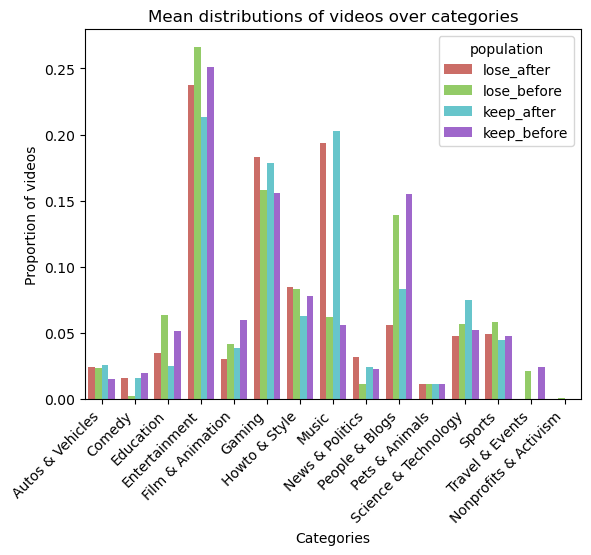

In [47]:
import seaborn as sns
video_distr_for_plotting = pd.concat(\
    [prop_videos_per_cat_l_a.mean(), prop_videos_per_cat_k_a.mean(), prop_videos_per_cat_l_b.mean(), prop_videos_per_cat_k_b.mean()], axis=1)\
    .rename(columns={0:"lose_after", 1:"lose_before", 2:"keep_after", 3:"keep_before"})

video_distr_for_plotting.reset_index(inplace=True)
video_distr_for_plotting = video_distr_for_plotting.melt('index', var_name='population', value_name='vals')

sns.barplot(data=video_distr_for_plotting, x="index", y="vals", hue="population", palette="hls")
plt.xticks(ticks = np.arange(0, len(categories)), labels = [cat.replace('categories_', '') for cat in video_distr_for_plotting["index"].unique()], rotation=45, ha="right");
plt.title("Mean distributions of videos over categories")
plt.ylabel("Proportion of videos")
plt.xlabel("Categories");

##### Statistical analysis of the distribution of videos over categories 

In [48]:
keep_fame_metavideos['before_fame'] = np.where(keep_fame_metavideos["upload_date"] > keep_fame_metavideos["max_growth_date"], 0, 1)
lose_fame_metavideos['before_fame'] = np.where(lose_fame_metavideos["upload_date"] > lose_fame_metavideos["max_growth_date"], 0, 1)
display(keep_fame_metavideos.sample(5))
keep_fame_metavideos.groupby("channel_id").count().shape

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_tags,max_growth_date,min_date,max_date,before_fame
26430,Entertainment,UCFs9b_YD0JNvBHYdJFA-Q1A,2019-11-10 22:14:09.593200,A tashin' on contest between Vicci and Gaz lea...,33.0,u4L2f_OoZW0,115,925.0,"Geordie,Shore,Charlotte,Vicky,Holly,Sophie,Jay...","Tashin' On Your Bike, Gaz! - Geordie Shore, Se...",2013-08-23 00:00:00,455061.0,14,2018-06-25 00:00:00,2018-04-02 00:00:00,2018-10-01 00:00:00,1
16678,Gaming,UCVh8euvzgedPxge8P1g0u3A,2019-11-18 01:49:33.341777,Fortnite streamer grinding to the top! Don’t f...,0.0,Ph_rNl1u3go,6456,16.0,"#PS4Live,PlayStation 4,Sony Interactive Entert...","Cross Platform Sub Games//450+ Wins// 14,000+ ...",2018-09-26 00:00:00,138.0,14,2019-04-08 00:00:00,2019-01-13 23:00:00,2019-07-15 00:00:00,1
29455,People & Blogs,UCCmuKNLE44T8kevpV6V6KFg,2019-11-20 21:28:51.922057,●● Walking Dead Locations Map: http://tinyurl....,2.0,y7ZtebXROic,214,14.0,"The Walking Dead (TV Program),Michonne (TV Cha...",The Walking Dead locations | Michonne - S3E1,2014-08-05 00:00:00,2553.0,19,2017-10-29 23:00:00,2017-08-07 00:00:00,2018-02-04 23:00:00,1
48650,Music,UC-N94lq6ncA1oR80sACQ5ZA,2019-11-07 21:45:30.338081,Provided to YouTube by avex trax\n\nI Think I ...,0.0,z9B9kqvdcuo,266,0.0,"Various Artists,バリアスアーティスツ,軽快なSoft EDM - foots...",I Think I Can,2019-01-14 00:00:00,4.0,4,2018-07-30 00:00:00,2018-05-07 00:00:00,2018-11-04 23:00:00,0
42743,Gaming,UC59rIGGDu6dvPD9rtJtXquQ,2019-11-01 11:19:26.763610,Asphalt 9 Legends - Gameplay Walkthrough Part ...,0.0,Piz47GA6x34,661,3.0,"asphalt 9,asphalt 9 gameplay,asphalt 9 android...",Asphalt 9 Legends - Gameplay Walkthrough Part ...,2018-05-02 00:00:00,237.0,22,2017-02-12 23:00:00,2016-11-20 23:00:00,2017-05-22 00:00:00,0


(163, 16)

In [49]:
contingency_table_lose = {}
results_lose = {}
for channel in lose_fame_metavideos['channel_id'].unique():
    
    if channel in contingency_table_lose:
        continue
    else:
        df_of_channel = lose_fame_metavideos[lose_fame_metavideos["channel_id"] == f"{channel}"]
        
        contingency_table_lose[f"{channel}"] = pd.crosstab(df_of_channel["before_fame"], df_of_channel["categories"])
        chi2, p, dof, expected = scs.chi2_contingency(contingency_table_lose[f"{channel}"])
        results_lose[f"{channel}"] = [chi2, p, dof, expected]

In [50]:
count_lose = 0
for key in results_lose:
    if results_lose[key][1] < 0.05:
        count_lose += 1
        print(f"{key}: chi-stat {results_lose[key][0]} -- p-value {results_lose[key][1]}")

UCphO96ypf0z0ynM5r5rDF6w: chi-stat 9.04779411764706 -- p-value 0.010846671081649481
UCpci_E3rz6pTveUgZMF6Jjg: chi-stat 251.2441839431392 -- p-value 2.7734392127288478e-55
UCytLmyg_OJXmNkHEMS0w2Cw: chi-stat 103.90337409506981 -- p-value 1.4506037339594293e-21
UCmHr3gIlwwgdj_kVTcW-yqw: chi-stat 17.529384703852784 -- p-value 0.00015615017524861662
UCmBMoU5ZDb44zwp47g3AInA: chi-stat 95.62818646795733 -- p-value 1.305219005738976e-15
UCl_Ksy6Yi1b4eEZ46FInb_w: chi-stat 101.55612027836764 -- p-value 2.0518552022786443e-18
UCj-J4HHrtX3gT9ZEWqAf2Dw: chi-stat 299.6415502796173 -- p-value 1.1894531885294357e-64
UCiTtO9FDqPGRqDMuSC74AQA: chi-stat 717.6894077690513 -- p-value 1.4312821093447912e-156
UCiIfXQzQUTQtHSgb4ce247g: chi-stat 748.4816717466243 -- p-value 8.581066057461583e-165
UCh8g7gphDveEEF9aFMaI7ig: chi-stat 57.01551743527193 -- p-value 5.019851114231217e-11
UCgvVxB6GKYpyZY1Hh9u-uSQ: chi-stat 24.270289097875303 -- p-value 2.1935687880202468e-05
UCfZtRrsy5LSboUqhImk0Zuw: chi-stat 64.20042

In [51]:
contingency_table_keep = {}
results_keep = {}

for channel in keep_fame_metavideos['channel_id'].unique():
    if channel in contingency_table_keep:
        continue
    else:
        df_of_channel = keep_fame_metavideos[keep_fame_metavideos["channel_id"] == f"{channel}"]
        
        contingency_table_keep[f"{channel}"] = pd.crosstab(df_of_channel["before_fame"], df_of_channel["categories"])
        chi2, p, dof, expected = scs.chi2_contingency(contingency_table_keep[f"{channel}"])
        results_keep[f"{channel}"] = [chi2, p, dof, expected]


In [52]:
count_keep = 0
for key in results_keep:
    if results_keep[key][1] < 0.05:
        count_keep += 1
        print(f"{key}: chi-stat {results_keep[key][0]} -- p-value {results_keep[key][1]}")

UCzVnXCLWqY5dtOBn9UZoFTw: chi-stat 52.67738831145983 -- p-value 3.930907933725064e-13
UCriQ6gvKEE0luxwCZ9VgA4A: chi-stat 34.57172096908939 -- p-value 3.110614388982518e-08
UCr-8JBJmj2eYXpGIgFzST1A: chi-stat 60.39669421487603 -- p-value 7.674047599313374e-14
UCqPS1mSh7_Wf4OIVuFA9Agw: chi-stat 48.80782749121307 -- p-value 2.520663794437544e-11
UCpX06BSn9ldkpoj-VBKSm3A: chi-stat 49.875 -- p-value 1.4783639290016492e-11
UCoinFia6rV2-KBdtfJYS5Yg: chi-stat 39.8633256772011 -- p-value 1.1390087221181828e-08
UClrXUuaH3E5vBSgZUWaTIhQ: chi-stat 45.520489708527734 -- p-value 7.171982565151192e-10
UClezEBZnheBeUM1OeYoBJyg: chi-stat 35.45323236955509 -- p-value 2.612484829443535e-09
UCidb8TVEeuYU5hIbKihD96A: chi-stat 6.441375830279433 -- p-value 0.011149226279644412
UCf0zY-GQ8N6MmLLqAvosnnQ: chi-stat 20.24691358024691 -- p-value 4.0127174287832265e-05
UCekZMO1ElC_qGzNGMRbNV_w: chi-stat 164.68000749451207 -- p-value 1.4489194699487956e-34
UCbmdXB3-xXt2bhe-Jz79qnw: chi-stat 198.49972908503278 -- p-va

In [53]:
print(f"Number of \"lose\" videos that significantly changed their distribution over categories: {count_lose}")
print(f"Number of \"keep\" videos that significantly changed their distribution over categories: {count_keep}")

Number of "lose" videos that significantly changed their distribution over categories: 65
Number of "keep" videos that significantly changed their distribution over categories: 60


## Analysis within categories
By looking at the two populations as they are, we didn't find any significant difference between the two groups. However, we wanted to see if there was any difference between the two groups within each category. To do so, we repeat each of the tests above within the most relevant channel categories present in the two populations.

In [54]:
categories_to_analyse = ["Entertainment", "Gaming", "Music", "Howto & Style"]

In [55]:
result = {}

for i in categories_to_analyse:
    dict_category = {}

    print(f"Category: {i}")
    
    # filter channels by category
    K_channels = keep_fame_channels[keep_fame_channels["category_cc"] == i]
    L_channels = lose_fame_channels[lose_fame_channels["category_cc"] == i]

    # filter by channel
    L_A_metavideos = lose_metavideos_after_sudden_growth[lose_metavideos_after_sudden_growth["channel_id"].isin(L_channels["channel"])]
    K_A_metavideos = keep_metavideos_after_sudden_growth[keep_metavideos_after_sudden_growth["channel_id"].isin(K_channels["channel"])]
    L_B_metavideos = lose_metavideos_before_sudden_growth[lose_metavideos_before_sudden_growth["channel_id"].isin(L_channels["channel"])]
    K_B_metavideos = keep_metavideos_before_sudden_growth[keep_metavideos_before_sudden_growth["channel_id"].isin(K_channels["channel"])]

    print(f"check shapes:   Lose After {L_A_metavideos.groupby('channel_id').count().shape} \
        Keep After {K_A_metavideos.groupby('channel_id').count().shape} \
        Lose before {L_B_metavideos.groupby('channel_id').count().shape} \
        Keep before {K_B_metavideos.groupby('channel_id').count().shape}")

    # filter time series dataframes
    L_ts = lose_fame_ts[lose_fame_ts["channel"].isin(L_A_metavideos["channel_id"])]
    K_ts = keep_fame_ts[keep_fame_ts["channel"].isin(K_A_metavideos["channel_id"])]

    # frequency of publication
    L_A_num_metavideos = L_A_metavideos.groupby("channel_id").count()['duration']
    K_A_num_metavideos = K_A_metavideos.groupby("channel_id").count()['duration']
    L_B_num_metavideos = L_B_metavideos.groupby("channel_id").count()['duration']
    K_B_num_metavideos = K_B_metavideos.groupby("channel_id").count()['duration']
   
    L_A_time = (L_ts.groupby("channel")['datetime'].max() - L_ts.groupby("channel")['max_growth_date'].mean()).dt.days
    K_A_time = (K_ts.groupby("channel")['datetime'].max() - K_ts.groupby("channel")['max_growth_date'].mean()).dt.days
    L_B_time = (L_ts.groupby("channel")['max_growth_date'].mean() - L_ts.groupby("channel")['datetime'].min()).dt.days
    K_B_time = (K_ts.groupby("channel")['max_growth_date'].mean() - K_ts.groupby("channel")['datetime'].min()).dt.days
    
    L_A_freq = L_A_num_metavideos / L_A_time
    K_A_freq = K_A_num_metavideos / K_A_time
    L_B_freq = L_B_num_metavideos / L_B_time
    K_B_freq = K_B_num_metavideos / K_B_time

    dict_category["freq_of_publication"] = {'L_A_freq': L_A_freq, 'K_A_freq': K_A_freq, 'L_B_freq': L_B_freq, 'K_B_freq': K_B_freq}

    # duration of videos
    L_A_duration = L_A_metavideos.groupby("channel_id").mean()['duration']
    K_A_duration = K_A_metavideos.groupby("channel_id").mean()['duration']
    L_B_duration = L_B_metavideos.groupby("channel_id").mean()['duration']
    K_B_duration = K_B_metavideos.groupby("channel_id").mean()['duration']

    dict_category["duration_of_videos"] = {'L_A_duration': L_A_duration, 'K_A_duration': K_A_duration, 'L_B_duration': L_B_duration, 'K_B_duration': K_B_duration}

    # number of tags
    L_A_num_tags = L_A_metavideos.groupby("channel_id").mean()['num_tags']
    K_A_num_tags = K_A_metavideos.groupby("channel_id").mean()['num_tags']
    L_B_num_tags = L_B_metavideos.groupby("channel_id").mean()['num_tags']
    K_B_num_tags = K_B_metavideos.groupby("channel_id").mean()['num_tags']

    dict_category["num_of_tags"] = {'L_A_num_tags': L_A_num_tags, 'K_A_num_tags': K_A_num_tags, 'L_B_num_tags': L_B_num_tags, 'K_B_num_tags': K_B_num_tags}

    result[i] = dict_category

Category: Entertainment
check shapes:   Lose After (23, 17)         Keep After (23, 17)         Lose before (23, 17)         Keep before (23, 17)
Category: Gaming
check shapes:   Lose After (14, 17)         Keep After (15, 17)         Lose before (14, 17)         Keep before (15, 17)
Category: Music
check shapes:   Lose After (15, 17)         Keep After (4, 17)         Lose before (15, 17)         Keep before (4, 17)
Category: Howto & Style
check shapes:   Lose After (9, 17)         Keep After (10, 17)         Lose before (9, 17)         Keep before (10, 17)


Statistical tests

In [56]:
for i in categories_to_analyse:
    print(f"Category: {i}\n")

    # frequency of publication tests
    print("Frequency of publication tests")
    # Keep videos
    stat, pval = scs.ttest_rel(result[i]["freq_of_publication"]["K_A_freq"], result[i]["freq_of_publication"]["K_B_freq"])
    print(f"    Keep videos: t-stat {stat} -- p-value {pval}")
    # Lose videos
    stat, pval = scs.ttest_rel(result[i]["freq_of_publication"]["L_A_freq"], result[i]["freq_of_publication"]["L_B_freq"])
    print(f"    Lose videos: t-stat {stat} -- p-value {pval}")
    # After videos
    stat, pval = scs.ttest_ind(result[i]["freq_of_publication"]["K_A_freq"], result[i]["freq_of_publication"]["L_A_freq"])
    print(f"    After videos: t-stat {stat} -- p-value {pval}")
    # Before videos
    stat, pval = scs.ttest_ind(result[i]["freq_of_publication"]["K_B_freq"], result[i]["freq_of_publication"]["L_B_freq"])
    print(f"    Before videos: t-stat {stat} -- p-value {pval}\n")

    # duration of videos tests
    print("Duration of videos tests")
    # Keep videos
    stat, pval = scs.ttest_rel(result[i]["duration_of_videos"]["K_A_duration"], result[i]["duration_of_videos"]["K_B_duration"])
    print(f"    Keep videos: t-stat {stat} -- p-value {pval}")
    # Lose videos
    stat, pval = scs.ttest_rel(result[i]["duration_of_videos"]["L_A_duration"], result[i]["duration_of_videos"]["L_B_duration"])
    print(f"    Lose videos: t-stat {stat} -- p-value {pval}")
    # After videos
    stat, pval = scs.ttest_ind(result[i]["duration_of_videos"]["K_A_duration"], result[i]["duration_of_videos"]["L_A_duration"])
    print(f"    After videos: t-stat {stat} -- p-value {pval}")
    # Before videos
    stat, pval = scs.ttest_ind(result[i]["duration_of_videos"]["K_B_duration"], result[i]["duration_of_videos"]["L_B_duration"])
    print(f"    Before videos: t-stat {stat} -- p-value {pval}\n")

    # number of tags tests
    print("Number of tags tests")
    # Keep videos
    stat, pval = scs.ttest_rel(result[i]["num_of_tags"]["K_A_num_tags"], result[i]["num_of_tags"]["K_B_num_tags"])
    print(f"    Keep videos: t-stat {stat} -- p-value {pval}")
    # Lose videos
    stat, pval = scs.ttest_rel(result[i]["num_of_tags"]["L_A_num_tags"], result[i]["num_of_tags"]["L_B_num_tags"])
    print(f"    Lose videos: t-stat {stat} -- p-value {pval}")
    # After videos
    stat, pval = scs.ttest_ind(result[i]["num_of_tags"]["K_A_num_tags"], result[i]["num_of_tags"]["L_A_num_tags"])
    print(f"    After videos: t-stat {stat} -- p-value {pval}")
    # Before videos
    stat, pval = scs.ttest_ind(result[i]["num_of_tags"]["K_B_num_tags"], result[i]["num_of_tags"]["L_B_num_tags"])
    print(f"    Before videos: t-stat {stat} -- p-value {pval}\n")

    print("--------------------------------------------------------------------------------------------------\n")


Category: Entertainment

Frequency of publication tests
    Keep videos: t-stat -0.8258840344271506 -- p-value 0.4177365892854782
    Lose videos: t-stat 1.325303230545698 -- p-value 0.19867035324961932
    After videos: t-stat -0.46816460955560535 -- p-value 0.6419777889642295
    Before videos: t-stat 0.975022078144864 -- p-value 0.3348795655224793

Duration of videos tests
    Keep videos: t-stat -0.6796268526959662 -- p-value 0.5038296486075295
    Lose videos: t-stat 0.5812617075012954 -- p-value 0.5669722944525799
    After videos: t-stat 1.4005010062726744 -- p-value 0.1683761815916034
    Before videos: t-stat 1.3888117315319988 -- p-value 0.17188025341433374

Number of tags tests
    Keep videos: t-stat -1.0967659489055823 -- p-value 0.28460426430501923
    Lose videos: t-stat -0.3456940193769969 -- p-value 0.732856485117602
    After videos: t-stat 0.9964092613902811 -- p-value 0.3244997099300092
    Before videos: t-stat 1.509498263120144 -- p-value 0.13831974947677259

----